# **Visual Search Project (202000689 고승찬)**
*   Exp 1: 240 trials (target different 120 trias + target identical 120 trials)
*   Exp 2: 300 trials (color mismatch 100 trials + color match 100 trials + non match 100 trials)

## **1. Model Definition**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Multiply, Input
from tensorflow.keras.models import Model

class VVC(Model):
    def __init__(self, input_shape):
        super(VVC, self).__init__()
        self.base_model = VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=input_shape))
        self.base_model.trainable = False
        self.target_layer_output = self.base_model.get_layer('block5_conv3').output
        self.global_avg_pool = GlobalAveragePooling2D(name="PFC_module")

    def call(self, inputs):
        target_output = Model(inputs=self.base_model.input, outputs=self.target_layer_output)(inputs)
        pooled_output = self.global_avg_pool(target_output)
        return pooled_output


class SearchModel(Model):
    def __init__(self, input_shape, input_shape_vvc):
        super(SearchModel, self).__init__()
        self.base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
        self.base_model.trainable = False
        self.search_layer_output = self.base_model.get_layer('block5_conv3').output
        self.vvc_output_shape = input_shape_vvc

    def call(self, inputs):
        search_image, vvc_output = inputs
        search_output = Model(inputs=self.base_model.input, outputs=self.search_layer_output)(search_image)
        vvc_output_broadcast = tf.reshape(vvc_output, [-1, 1, 1, self.vvc_output_shape[-1]])
        combined_features = Multiply()([search_output, vvc_output_broadcast])
        return combined_features

vvc_input_shape = (56, 56, 3)
input_shape_vvc = (512,)
search_input_shape = (224, 224, 3)

vvc_model = VVC(vvc_input_shape)
search_model = SearchModel(search_input_shape, input_shape_vvc)

# example data
vvc_image = tf.random.normal([1, 56, 56, 3])
search_image = tf.random.normal([1, 224, 224, 3])
vvc_output = vvc_model(vvc_image)

final_output = search_model([search_image, vvc_output])
print("Final output shape:", final_output.shape)


Final output shape: (1, 14, 14, 512)


VVC Model visualization saved as VVC_Model.png
Search Model visualization saved as Search_Model.png


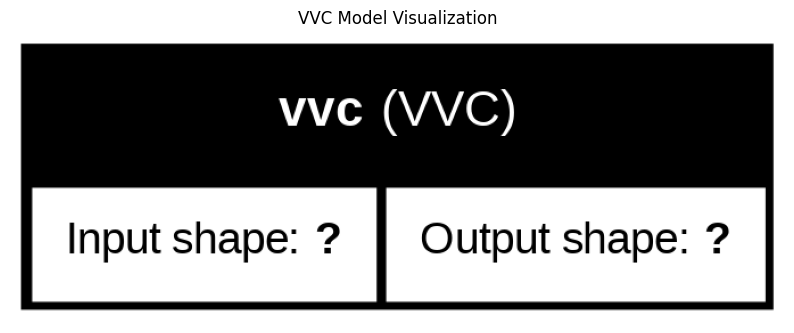

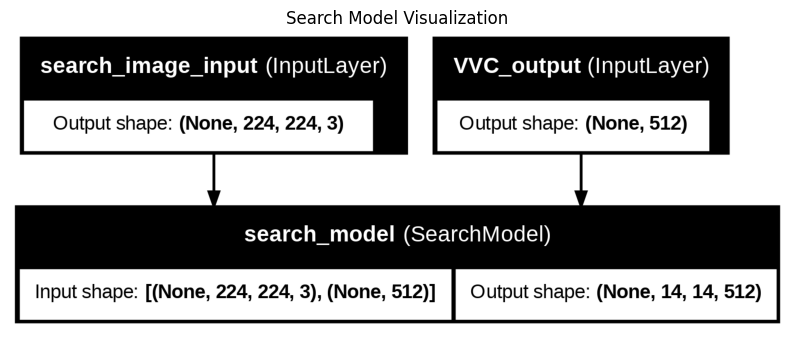

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import plot_model

# 더미 데이터 생성
vvc_dummy_data = tf.random.normal([1, 56, 56, 3])
search_dummy_data = tf.random.normal([1, 224, 224, 3])

# 더미 데이터로 모델 호출하여 구조 확정
vvc_output = vvc_model(vvc_dummy_data)
search_output = search_model([search_dummy_data, vvc_output])

# 모델 시각화
plot_model(vvc_model, to_file='VVC_Model.png', show_shapes=True, show_layer_names=True, rankdir='TB')
print("VVC Model visualization saved as VVC_Model.png")

# SearchModel의 더미 데이터 입력 및 시각화 준비
vvc_output_dummy = tf.keras.Input(shape=(512,), name='VVC_output')
search_image_dummy = tf.keras.Input(shape=(224, 224, 3), name='search_image_input')
dummy_model = Model(inputs=[search_image_dummy, vvc_output_dummy], outputs=search_model([search_image_dummy, vvc_output_dummy]))

plot_model(dummy_model, to_file='Search_Model.png', show_shapes=True, show_layer_names=True, rankdir='TB')
print("Search Model visualization saved as Search_Model.png")

# VVC 모델 시각화
vvc_image = Image.open('VVC_Model.png')
plt.figure(figsize=(10, 10))
plt.imshow(vvc_image)
plt.axis('off')  # 축을 표시하지 않음
plt.title('VVC Model Visualization')
plt.show()

# Search 모델 시각화
search_image = Image.open('Search_Model.png')
plt.figure(figsize=(10, 10))
plt.imshow(search_image)
plt.axis('off')
plt.title('Search Model Visualization')
plt.show()


## **2. Attention map overlay processing 예제**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Cosine Similarity between Image 1 and Image 2: 0.2679


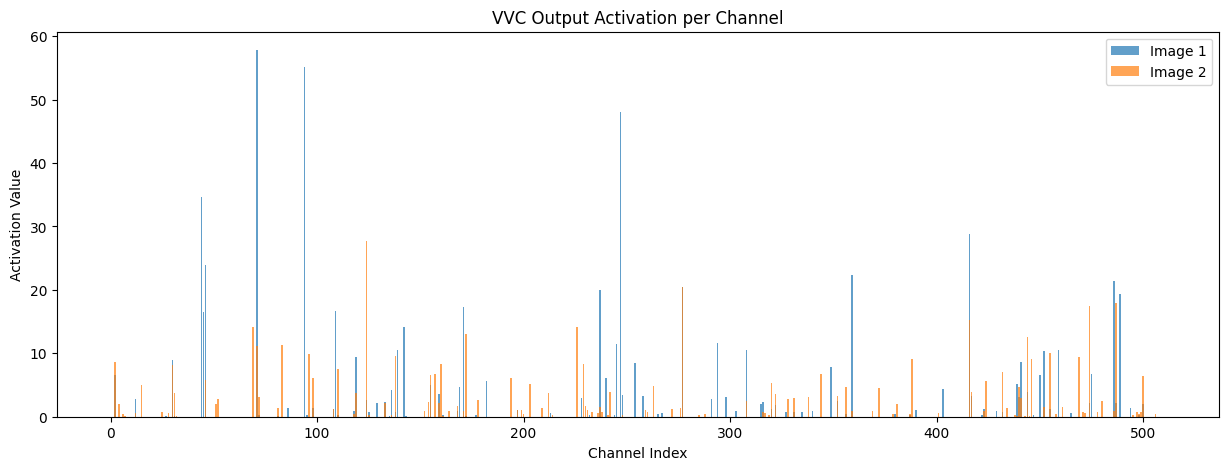

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import cv2

# target image를 불러와 target size로 전처리
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    return img

target_img0 = preprocess_image('/content/drive/MyDrive/Project/Exp1/target/1.jpg', target_size=(56, 56))
target_img1 = preprocess_image('/content/drive/MyDrive/Project/Exp2/target/1.jpg', target_size=(56, 56))

# VVC 모델에서 feature vector 추출
vvc_output0 = vvc_model.predict(target_img0)  # Output: (1, 512)
vvc_output1 = vvc_model.predict(target_img1)  # Output: (1, 512)

# 두 이미지의 feature vector 간 Cosine Similarity 확인
similarity = cosine_similarity(vvc_output0, vvc_output1)
print(f"Cosine Similarity between Image 1 and Image 2: {similarity[0][0]:.4f}")

# output 시각화 (1x512 output이므로 1차원 그래프로 표시)
output0_flatten = vvc_output0.flatten()
output1_flatten = vvc_output1.flatten()

# 각 채널의 활성화 정도 시각화
plt.figure(figsize=(15, 5))
plt.bar(range(len(output0_flatten)), output0_flatten, alpha=0.7, label="Image 1")
plt.bar(range(len(output1_flatten)), output1_flatten, alpha=0.7, label="Image 2")
plt.title("VVC Output Activation per Channel")
plt.xlabel("Channel Index")
plt.ylabel("Activation Value")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


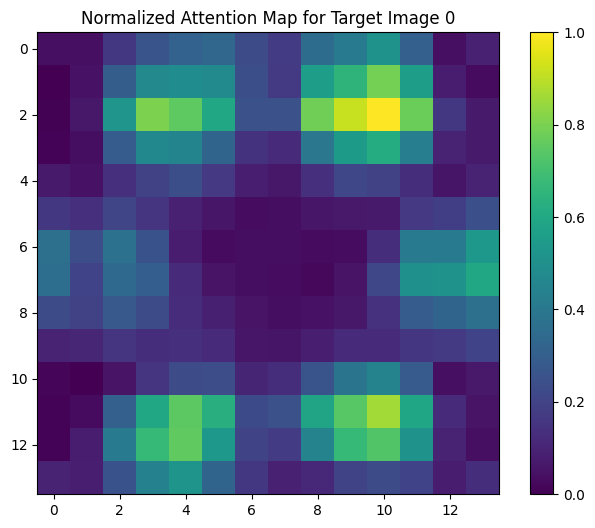

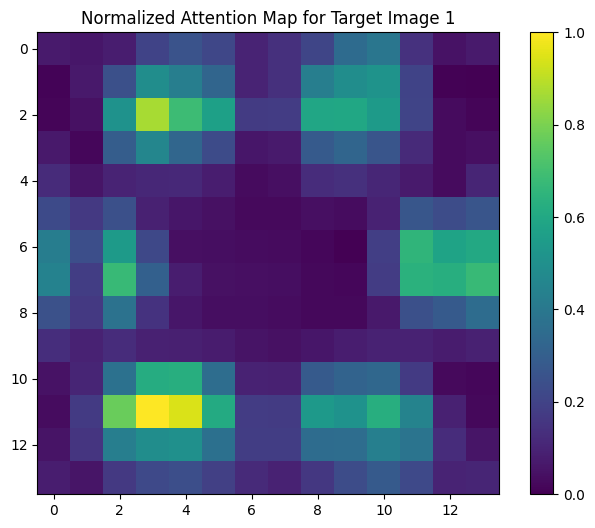

In [ ]:
# Reshape VVC outputs: VVC 모델의 2D output(1x512)을 4D(1x1x1x512)로 변환
vvc_output0_reshaped = tf.expand_dims(tf.expand_dims(vvc_output0, axis=1), axis=1) # Shape: (1x1x1x512)
vvc_output1_reshaped = tf.expand_dims(tf.expand_dims(vvc_output1, axis=1), axis=1) # Shape: (1x1x1x512)

# search image를 불러와 target size (224x224)로 전처리
search_img0 = preprocess_image('/content/drive/MyDrive/Project/Exp1/array/circular_array_1.png', target_size=(224, 224))
search_img1 = preprocess_image('/content/drive/MyDrive/Project/Exp2/array/circular_array_1.png', target_size=(224, 224))

# Search 모델에서 top-down modulation을 통해 attention map 추출
attention_map0 = search_model.predict([search_img0, vvc_output0_reshaped])  # Output: (1, 14, 14, 512)
attention_map1 = search_model.predict([search_img1, vvc_output1_reshaped])  # Output: (1, 14, 14, 512)

## attention map 시각화
# 1. 1x14x14x512 형태인 attention map을 512개의 channel을 평균내어 1x14x14x1 형태의 attention map 생성
attention_map0_reduced = tf.reduce_mean(attention_map0, axis=-1, keepdims=True)  # Output: (1, 14, 14, 1)
attention_map1_reduced = tf.reduce_mean(attention_map1, axis=-1, keepdims=True)  # Output: (1, 14, 14, 1)

# 2. 시각화를 위해 2D로 변환
attention_map0_2d = tf.squeeze(attention_map0_reduced, axis=[0, -1])  # Output: (14, 14)
attention_map1_2d = tf.squeeze(attention_map1_reduced, axis=[0, -1])  # Output: (14, 14)

# 3. 활성화 값을 시각화를 위해 0~1의 값으로 normalization
attention_map0_normalized = (attention_map0_2d - tf.reduce_min(attention_map0_2d)) / (tf.reduce_max(attention_map0_2d) - tf.reduce_min(attention_map0_2d))
attention_map1_normalized = (attention_map1_2d - tf.reduce_min(attention_map1_2d)) / (tf.reduce_max(attention_map1_2d) - tf.reduce_min(attention_map1_2d))

# 4. matrix를 numpy로 변환
attention_map0_normalized_np = attention_map0_normalized.numpy()
attention_map1_normalized_np = attention_map1_normalized.numpy()

# Plot normalized attention map for Target Image 0
plt.figure(figsize=(8, 6))
plt.imshow(attention_map0_normalized_np, cmap='viridis')
plt.colorbar()
plt.title("Normalized Attention Map for Target Image 0")
plt.show()

# Plot normalized attention map for Target Image 1
plt.figure(figsize=(8, 6))
plt.imshow(attention_map1_normalized_np, cmap='viridis')
plt.colorbar()
plt.title("Normalized Attention Map for Target Image 1")
plt.show()


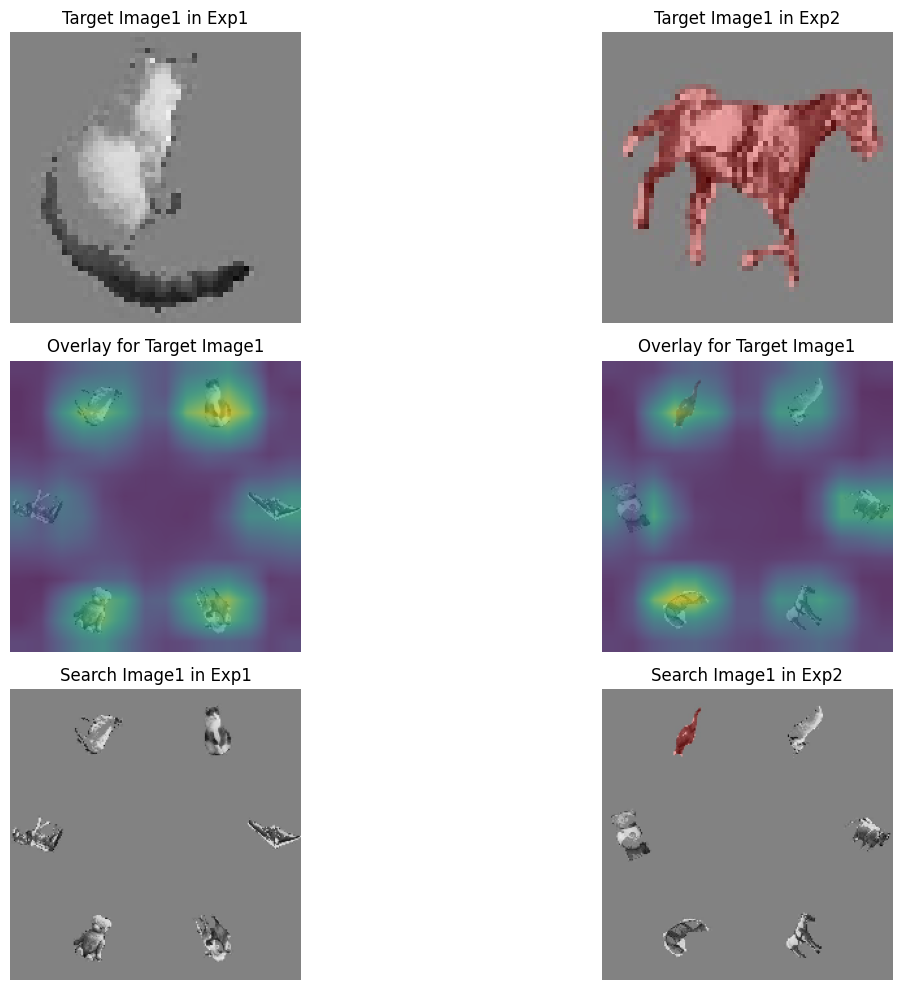

In [ ]:
## Overlay Attention Map 시각화

# 1. Attention map을 시각화 및 처리하기 위해 channel dimension 추가
attention_map0_normalized = tf.expand_dims(attention_map0_normalized, axis=-1)  # Shape: (14, 14, 1)
attention_map1_normalized = tf.expand_dims(attention_map1_normalized, axis=-1)  # Shape: (14, 14, 1)

# 2. 224x224 크기의 search image와 attention map 크기를 맞춤
attention_map0_resized = tf.image.resize(attention_map0_normalized, (224, 224)).numpy()
attention_map1_resized = tf.image.resize(attention_map1_normalized, (224, 224)).numpy()

# 3. Viridis color map을 적용하여 heatmap 생성
attention_map0_colored = cv2.applyColorMap((attention_map0_resized * 255).astype(np.uint8), cv2.COLORMAP_VIRIDIS)
attention_map1_colored = cv2.applyColorMap((attention_map1_resized * 255).astype(np.uint8), cv2.COLORMAP_VIRIDIS)

# 4. heatmap을 RGB 형식으로 변환
attention_map0_colored = cv2.cvtColor(attention_map0_colored, cv2.COLOR_BGR2RGB)
attention_map1_colored = cv2.cvtColor(attention_map1_colored, cv2.COLOR_BGR2RGB)

# 5. Search 이미지를 NumPy 배열로 변환하고 [0, 1] 범위로 정규화
search_img0_np = search_img0[0].numpy() / 255.0
search_img1_np = search_img1[0].numpy() / 255.0

# 6. Attention map을 [0, 1] 범위로 정규화
attention_map0_colored = attention_map0_colored.astype(np.float32) / 255.0
attention_map1_colored = attention_map1_colored.astype(np.float32) / 255.0

# 7. Heatmap과 원본 이미지를 투명도 0.6으로 중첩
overlay_alpha = 0.6  # Transparency factor
overlay0 = cv2.addWeighted(search_img0_np, 1 - overlay_alpha, attention_map0_colored, overlay_alpha, 0)
overlay1 = cv2.addWeighted(search_img1_np, 1 - overlay_alpha, attention_map1_colored, overlay_alpha, 0)

# Target image를 시각화하기 위한 형태로 변환
target_img0_np = target_img0[0].numpy() / 255.0  # Normalize to [0, 1]
target_img1_np = target_img1[0].numpy() / 255.0

# Plot Target Images, Overlays, and Search Images
plt.figure(figsize=(15, 10))

# Target Image 0
plt.subplot(3, 2, 1)
plt.imshow(target_img0_np)
plt.title("Target Image1 in Exp1")
plt.axis('off')

# Target Image 1
plt.subplot(3, 2, 2)
plt.imshow(target_img1_np)
plt.title("Target Image1 in Exp2")
plt.axis('off')

# Overlay 0
plt.subplot(3, 2, 3)
plt.imshow(overlay0)
plt.title("Overlay for Target Image1")
plt.axis('off')

# Overlay 1
plt.subplot(3, 2, 4)
plt.imshow(overlay1)
plt.title("Overlay for Target Image1")
plt.axis('off')

# Search Image 0
plt.subplot(3, 2, 5)
plt.imshow(search_img0_np)
plt.title("Search Image1 in Exp1")
plt.axis('off')

# Search Image 1
plt.subplot(3, 2, 6)
plt.imshow(search_img1_np)
plt.title("Search Image1 in Exp2")
plt.axis('off')

plt.tight_layout()
plt.show()


## **3. Attention map overlay processing for the dataset**

In [ ]:
import os
from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import numpy as np
import cv2

# 이미지 전처리
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    return img

# Attention Map 생성
def generate_attention_map(search_img, vvc_output, search_model):
    vvc_output_reshaped = tf.expand_dims(tf.expand_dims(vvc_output, axis=1), axis=1)  # Shape: (1, 1, 1, 512)
    attention_map = search_model.predict([search_img, vvc_output_reshaped])  # Output: (1, 14, 14, 512)
    attention_map_reduced = tf.reduce_mean(attention_map, axis=-1, keepdims=True)  # Output: (1, 14, 14, 1)
    attention_map_2d = tf.squeeze(attention_map_reduced, axis=[0, -1])  # Output: (14, 14)
    attention_map_normalized = (attention_map_2d - tf.reduce_min(attention_map_2d)) / (
        tf.reduce_max(attention_map_2d) - tf.reduce_min(attention_map_2d)
    )
    return attention_map_normalized

# Heatmap Overlay 생성
def overlay_heatmap(search_img, attention_map_normalized, alpha=0.6):
    attention_map_resized = tf.image.resize(tf.expand_dims(attention_map_normalized, axis=-1), (224, 224)).numpy()
    attention_map_colored = cv2.applyColorMap((attention_map_resized * 255).astype(np.uint8), cv2.COLORMAP_VIRIDIS)
    attention_map_colored = cv2.cvtColor(attention_map_colored, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    search_img_np = search_img[0].numpy().astype(np.float32) / 255.0
    overlay = cv2.addWeighted(search_img_np, 1 - alpha, attention_map_colored, alpha, 0)
    return overlay

In [ ]:
## 1. Exp1 dataset processing

# 경로 설정
target_dir = '/content/drive/MyDrive/Project/Exp1/target'
search_dir = '/content/drive/MyDrive/Project/Exp1/array'
output_dir = '/content/drive/MyDrive/Project/Exp1/heatmap'
os.makedirs(output_dir, exist_ok=True)


for i in range(1, 241):
    target_image_path = os.path.join(target_dir, f"{i}.jpg")
    search_image_path = os.path.join(search_dir, f"circular_array_{i}.png")
    output_image_path = os.path.join(output_dir, f"heatmap_{i}.png")

    # 이미지 전처리
    target_img = preprocess_image(target_image_path, target_size=(56, 56))
    search_img = preprocess_image(search_image_path, target_size=(224, 224))

    # VVC 출력 생성
    vvc_output = vvc_model.predict(target_img)

    # Attention Map 생성
    attention_map_normalized = generate_attention_map(search_img, vvc_output, search_model)

    # Heatmap Overlay 생성
    overlay = overlay_heatmap(search_img, attention_map_normalized)

    # Overlay 저장
    overlay_bgr = (overlay * 255).astype(np.uint8)  # OpenCV는 BGR 포맷으로 저장
    cv2.imwrite(output_image_path, cv2.cvtColor(overlay_bgr, cv2.COLOR_RGB2BGR))

    print(f"Saved heatmap for image {i} at {output_image_path}")

print("All heatmaps have been generated and saved.")

In [ ]:
## 2. Exp2 dataset processing
# 경로 설정
target_dir = '/content/drive/MyDrive/Project/Exp2/target'
search_dir = '/content/drive/MyDrive/Project/Exp2/array'
output_dir = '/content/drive/MyDrive/Project/Exp2/heatmap'
os.makedirs(output_dir, exist_ok=True)


for i in range(1, 301):
    target_image_path = os.path.join(target_dir, f"{i}.jpg")
    search_image_path = os.path.join(search_dir, f"circular_array_{i}.png")
    output_image_path = os.path.join(output_dir, f"heatmap_{i}.png")

    # 이미지 전처리
    target_img = preprocess_image(target_image_path, target_size=(56, 56))
    search_img = preprocess_image(search_image_path, target_size=(224, 224))

    # VVC 출력 생성
    vvc_output = vvc_model.predict(target_img)

    # Attention Map 생성
    attention_map_normalized = generate_attention_map(search_img, vvc_output, search_model)

    # Heatmap Overlay 생성
    overlay = overlay_heatmap(search_img, attention_map_normalized)

    # Overlay 저장
    overlay_bgr = (overlay * 255).astype(np.uint8)  # OpenCV는 BGR 포맷으로 저장
    cv2.imwrite(output_image_path, cv2.cvtColor(overlay_bgr, cv2.COLOR_RGB2BGR))

    print(f"Saved heatmap for image {i} at {output_image_path}")

print("All heatmaps have been generated and saved.")


## **4. Visual Search 알고리즘 및 Fixation 예제**

Center coordinates for each image within a 224x224 canvas:
Image 1: Center at (203, 112)
Image 2: Center at (157, 191)
Image 3: Center at (67, 191)
Image 4: Center at (21, 112)
Image 5: Center at (67, 33)
Image 6: Center at (157, 33)


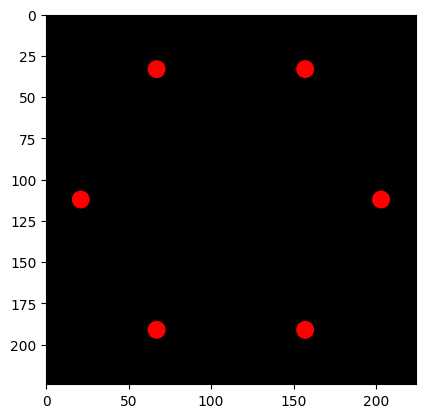

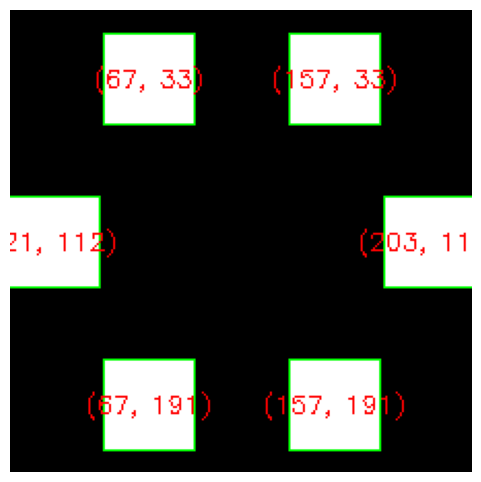

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## search image에서 object의 좌표 구하기
original_canvas_size = 800  # 기존 캔버스 크기
scaled_canvas_size = 224
radius_ratio = scaled_canvas_size / original_canvas_size
radius = 327 * radius_ratio
image_size = (224, 224)
num_images = 6

# Calculate the angles for image placement
angles = np.linspace(0, 2 * np.pi, num_images, endpoint=False)

# Calculate center coordinates for each image, scaled to fit in 224x224
image_centers = []
for angle in angles:
    x = int(scaled_canvas_size / 2 + radius * np.cos(angle) - image_size[0] / 2)
    y = int(scaled_canvas_size / 2 + radius * np.sin(angle) - image_size[1] / 2)
    image_centers.append((x + image_size[0] // 2, y + image_size[1] // 2))

# Display the results
print("Center coordinates for each image within a 224x224 canvas:")
for idx, center in enumerate(image_centers, start=1):
    print(f"Image {idx}: Center at {center}")

# Optional: Plotting the points on a canvas to visualize
fig, ax = plt.subplots()
ax.imshow(np.zeros((scaled_canvas_size, scaled_canvas_size, 3), dtype=np.uint8), extent=[0, scaled_canvas_size, 0, scaled_canvas_size])
for center in image_centers:
    circle = plt.Circle(center, 5, color='red', fill=True)
    ax.add_patch(circle)
ax.set_xlim(0, scaled_canvas_size)
ax.set_ylim(0, scaled_canvas_size)
ax.set_aspect('equal')
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.show()


# 224x224 이미지 생성 (배경은 검은색)
image = np.zeros((224, 224, 3), dtype=np.uint8)

# 이미지 중심 좌표 및 크기
center_positions = [(203, 112), (157, 191), (67, 191), (21, 112), (67, 33), (157, 33)]
image_size = 44  # 스케일 다운된 이미지 크기

# 각 중심 위치에 테두리를 그리고 이미지 추가 (여기서는 간단한 흰색 사각형으로 대체)
for center in center_positions:
    top_left = (center[0] - image_size // 2, center[1] - image_size // 2)
    bottom_right = (center[0] + image_size // 2, center[1] + image_size // 2)
    cv2.rectangle(image, top_left, bottom_right, (255, 255, 255), -1)  # 흰색 사각형으로 이미지 영역 표시
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 1)  # 테두리 그리기 (녹색)

    # 중심 좌표 표시
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = f"({center[0]}, {center[1]})"
    text_size = cv2.getTextSize(text, font, 0.4, 1)[0]
    text_x = center[0] - text_size[0] // 2
    text_y = center[1] + text_size[1] // 2
    cv2.putText(image, text, (text_x, text_y), font, 0.4, (255, 0, 0), 1)

# 이미지 출력
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 데이터 준비
file_path = '/content/drive/MyDrive/Project/Exp1/data.xlsx'
data = pd.read_excel(file_path)

# Location 정의 (데이터에서의 tloc 좌표)
locations = {
    0: (33, 157),
    1: (112, 203),
    2: (191, 157),
    3: (191, 67),
    4: (112, 21),
    5: (33, 67)
}

# Target Label 정의
target_labels = {
    0: "cat",
    1: "cattle",
    2: "horse",
    3: "kite",
    4: "sheep",
    5: "teddybear"
}


def define_ROI(fixed_locations, region_size=22):
    """
    Reigion Of Interest 정의 (44x44 matrix 생성).
    """
    return [
        (
            max(0, y - region_size), min(224, y + region_size),
            max(0, x - region_size), min(224, x + region_size)
        )
        for y, x in fixed_locations
    ]


def WTA_with_IOR(attention_map, search_regions, target_region_index, max_fixations=6):
    """
     Winner-Take-All mechanism을 기반으로 Attention Map에서 최대 활성화 지점을 탐색.
    """
    attention_map = attention_map.copy()
    fixation_points = [(112, 112)]  # 초기 고정점: Attention Map 중심
    excluded_regions = set()  # 탐색에서 제외된 영역

    for _ in range(max_fixations):
        max_value, max_location, max_region_index = -np.inf, None, None

        # 현재 탐색 가능한 영역 중 활성화 최대값 찾기
        for i, region in enumerate(search_regions): # search_regions은 ROI로 정의된 6개의 44x44 크기 영역
            if i in excluded_regions:
                continue
            y_min, y_max, x_min, x_max = region
            region_values = attention_map[y_min:y_max, x_min:x_max]
            local_max_idx = np.unravel_index(np.argmax(region_values), region_values.shape)
            global_max_idx = (y_min + local_max_idx[0], x_min + local_max_idx[1])

            if attention_map[global_max_idx] > max_value:
                max_value, max_location, max_region_index = attention_map[global_max_idx], global_max_idx, i
            print(max_value)

        # target object가 위치한 목표 영역인지 확인
        if max_region_index == target_region_index:
            fixation_points.append(max_location)
            return fixation_points, True

        # 목표 영역이 아니면 해당 영역 제외(Inhibition Of Region 적용)
        excluded_regions.add(max_region_index)
        fixation_points.append(max_location)

    return fixation_points, False


def visualize_search(attention_map, fixation_points):
    """
    탐색 경로를 시각화. 중심 fixation은 '+'로 표시
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(attention_map, cmap="viridis")

    for i, (y, x) in enumerate(fixation_points):
        if i == 0:
            plt.plot(x, y, marker='+', markersize=12, color="red", label="Center Fixation")
        else:
            plt.scatter(x, y, c="red", label="Fixation" if i == 1 else None)
            plt.text(x, y, str(i), color="white", fontsize=8)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
    plt.title("Search Process")
    plt.show()


# Fixed Locations 및 IOR 정의
fixed_locations = list(locations.values())
search_regions = define_ROI(fixed_locations, region_size=22)


3 2 1
0.5764705882352941
0.807843137254902
0.807843137254902
0.807843137254902
0.8627450980392157
0.8627450980392157
0.5764705882352941
0.807843137254902
0.807843137254902
0.807843137254902
0.807843137254902
Target 'horse' found at (104, 193) after 2 fixations.


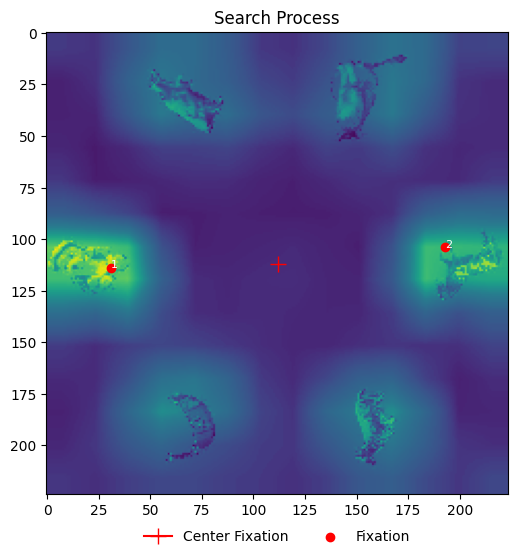

In [ ]:
image_idx = 3

# Attention Map 로드 (예제용: 특정 trial에 대해 실행)
trial = data.loc[image_idx-1, 'trials']
target_id = data.loc[image_idx-1, 'tid']
target_loc_id = data.loc[image_idx-1, 'tloc']
print(trial, target_id, target_loc_id)

# Target 정보 설정
target_label = target_labels[target_id]
target_region_index = target_loc_id

# Attention Map 로드 및 정규화
attention_map_path = (f'/content/drive/MyDrive/Project/Exp1/heatmap/heatmap_{image_idx}.png')
attention_map_image = cv2.imread(attention_map_path, cv2.IMREAD_GRAYSCALE)
attention_map = attention_map_image / 255.0  # Normalize to [0, 1]

# 탐색 실행
fixation_points, found = WTA_with_IOR(
    attention_map,
    search_regions,
    target_region_index,
    max_fixations=6
)

# 결과 출력
if found:
    print(f"Target '{target_label}' found at {fixation_points[-1]} after {len(fixation_points)-1} fixations.")
else:
    print(f"Target '{target_label}' not found after {len(fixation_points)-1} fixations.")

# 탐색 시각화
visualize_search(attention_map, fixation_points)

## **5. Fixation processing for the dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Location 정의 (데이터에서의 tloc 좌표)
locations = {
    0: (33, 157),
    1: (112, 203),
    2: (191, 157),
    3: (191, 67),
    4: (112, 21),
    5: (33, 67)
}

# Target Label 정의
target_labels = {
    0: "cat",
    1: "cattle",
    2: "horse",
    3: "kite",
    4: "sheep",
    5: "teddybear"
}

def define_ROI(fixed_locations, region_size=22):
    """
    Reigion Of Interest 정의 (44x44 matrix 생성).
    """
    return [
        (
            max(0, y - region_size), min(224, y + region_size),
            max(0, x - region_size), min(224, x + region_size)
        )
        for y, x in fixed_locations
    ]

def WTA_with_IOR(attention_map, search_regions, target_region_index, max_fixations=6):
    """
    Attention Map을 기반으로 목표를 탐색.
    """
    attention_map = attention_map.copy()
    fixation_points = [(112, 112)]  # 초기 고정점: Attention Map 중심
    excluded_regions = set()  # 탐색에서 제외된 영역

    for _ in range(max_fixations):
        max_value, max_location, max_region_index = -np.inf, None, None

        for i, region in enumerate(search_regions):
            if i in excluded_regions:
                continue
            y_min, y_max, x_min, x_max = region
            region_values = attention_map[y_min:y_max, x_min:x_max]
            local_max_idx = np.unravel_index(np.argmax(region_values), region_values.shape)
            global_max_idx = (y_min + local_max_idx[0], x_min + local_max_idx[1])

            if attention_map[global_max_idx] > max_value:
                max_value, max_location, max_region_index = attention_map[global_max_idx], global_max_idx, i

        if max_region_index == target_region_index:
            fixation_points.append(max_location)
            return fixation_points, True

        excluded_regions.add(max_region_index)
        fixation_points.append(max_location)

    return fixation_points, False

def is_fixation_in_region(fixation, center, region_radius=22):
    """
    특정 Fixation이 주어진 중심 영역(center) 안에 있는지 확인.
    """
    fy, fx = fixation
    cy, cx = center
    return abs(fy - cy) <= region_radius and abs(fx - cx) <= region_radius

def save_visualization(attention_map, fixation_points, image_idx, output_dir):
    """
    탐색 경로를 표시한 이미지를 저장.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(attention_map, cmap="viridis")

    for i, (y, x) in enumerate(fixation_points):
        if i == 0:
            plt.plot(x, y, marker='+', markersize=8, color="red")  # 초기 Fixation (중심)
        else:
            plt.scatter(x, y, c="red", s=10)  # 나머지 Fixation
        plt.text(x, y, str(i), color="white", fontsize=8)  # Fixation 번호 표시

    plt.axis("off")  # 축 숨기기
    plt.savefig(f"{output_dir}/search_{image_idx}.png")
    plt.close()

# Fixed Locations 및 ROI 정의
fixed_locations = list(locations.values())
search_regions = define_ROI(fixed_locations, region_size=22)

In [ ]:
## Exp 1. fixation 생성

# 데이터 준비
file_path = '/content/drive/MyDrive/Project/Exp1/data.xlsx'
data = pd.read_excel(file_path)

# Output 경로 설정
output_dir = "/content/drive/MyDrive/Project/Exp1/output_images"
os.makedirs(output_dir, exist_ok=True)

# Fixed Locations 및 ROI 정의
fixed_locations = list(locations.values())
search_regions = define_ROI(fixed_locations, region_size=22)

# 결과 저장 리스트
results = []

# 이미지 1~241 반복 실행
for image_idx in range(1, 241):
    trial = data.loc[image_idx - 1, 'trials']
    target_id = data.loc[image_idx - 1, 'tid']
    target_loc_id = data.loc[image_idx - 1, 'tloc']

    target_label = target_labels[target_id]
    target_region_index = target_loc_id

    # Attention Map 로드
    attention_map_path = f'/content/drive/MyDrive/Project/Exp1/heatmap/heatmap_{image_idx}.png'
    attention_map_image = cv2.imread(attention_map_path, cv2.IMREAD_GRAYSCALE)

    # 이미지가 없을 경우 스킵
    if attention_map_image is None:
        print(f"Attention Map for Image {image_idx} not found. Skipping...")
        continue

    attention_map = attention_map_image / 255.0  # Normalize to [0, 1]

    # 탐색 실행
    fixation_points, found = WTA_with_IOR(
        attention_map,
        search_regions,
        target_region_index,
        max_fixations=6
    )


    # 결과 저장
    results.append({
        "image_idx": image_idx,
        "trial": trial,
        "target_label": target_label,
        "target_location": locations[target_region_index],
        "fixations_count": len(fixation_points) - 1,
        "found": found,
    })

    # 탐색 경로 이미지 저장
    save_visualization(attention_map, fixation_points, image_idx, output_dir)

    # 진행 상태 출력
    print(f"Processed Image {image_idx}: Target {'found' if found else 'not found'} after {len(fixation_points) - 1} fixations.")

# CSV 파일 저장
results_df = pd.DataFrame(results)
results_csv_path = "/content/drive/MyDrive/Project/Exp1/search_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")

In [ ]:
## Exp 2. fixation 생성

# 데이터 준비
file_path = '/content/drive/MyDrive/Project/Exp2/data.xlsx'
data = pd.read_excel(file_path)

# Output 경로 설정
output_dir = "/content/drive/MyDrive/Project/Exp2/output_images"
os.makedirs(output_dir, exist_ok=True)

# Fixed Locations 및 ROI 정의
fixed_locations = list(locations.values())
search_regions = define_ROI(fixed_locations, region_size=22)

# 결과 저장 리스트
results = []

# 이미지 1~301 반복 실행
for image_idx in range(1, 301):
    trial = data.loc[image_idx - 1, 'trials']
    target_id = data.loc[image_idx - 1, 'tid']
    target_loc_id = data.loc[image_idx - 1, 'tloc']
    salient_loc_id = data.loc[image_idx - 1, 'sloc']

    target_label = target_labels[target_id]
    target_region_index = target_loc_id

    # Attention Map 로드
    attention_map_path = f'/content/drive/MyDrive/Project/Exp2/heatmap/heatmap_{image_idx}.png'
    attention_map_image = cv2.imread(attention_map_path, cv2.IMREAD_GRAYSCALE)

    # 이미지가 없을 경우 스킵
    if attention_map_image is None:
        print(f"Attention Map for Image {image_idx} not found. Skipping...")
        continue

    attention_map = attention_map_image / 255.0  # Normalize to [0, 1]

    # 탐색 실행
    fixation_points, found = WTA_with_IOR(
        attention_map,
        search_regions,
        target_region_index,
        max_fixations=6
    )

    # sloc 검사
    if salient_loc_id == -1:
        sloc_fixation_index = -1  # salient distractor 없음
    else:
        sloc_center = locations[salient_loc_id]
        sloc_fixation_index = -2  # 초기값: 존재하지만 찍히지 않음
        for idx, fixation in enumerate(fixation_points):
            if is_fixation_in_region(fixation, sloc_center):
                sloc_fixation_index = idx
                break

    # 결과 저장
    results.append({
        "image_idx": image_idx,
        "trial": trial,
        "target_label": target_label,
        "target_location": locations[target_region_index],
        "fixations_count": len(fixation_points) - 1,
        "found": found,
        "sloc_fixation_index": sloc_fixation_index
    })

    # 탐색 경로 이미지 저장
    save_visualization(attention_map, fixation_points, image_idx, output_dir)

    # 진행 상태 출력
    print(f"Processed Image {image_idx}: Target {'found' if found else 'not found'} after {len(fixation_points) - 1} fixations.")

# CSV 파일 저장
results_df = pd.DataFrame(results)
results_csv_path = "/content/drive/MyDrive/Project/Exp2/search_results.csv"
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to {results_csv_path}")


## **6. Result visualization**

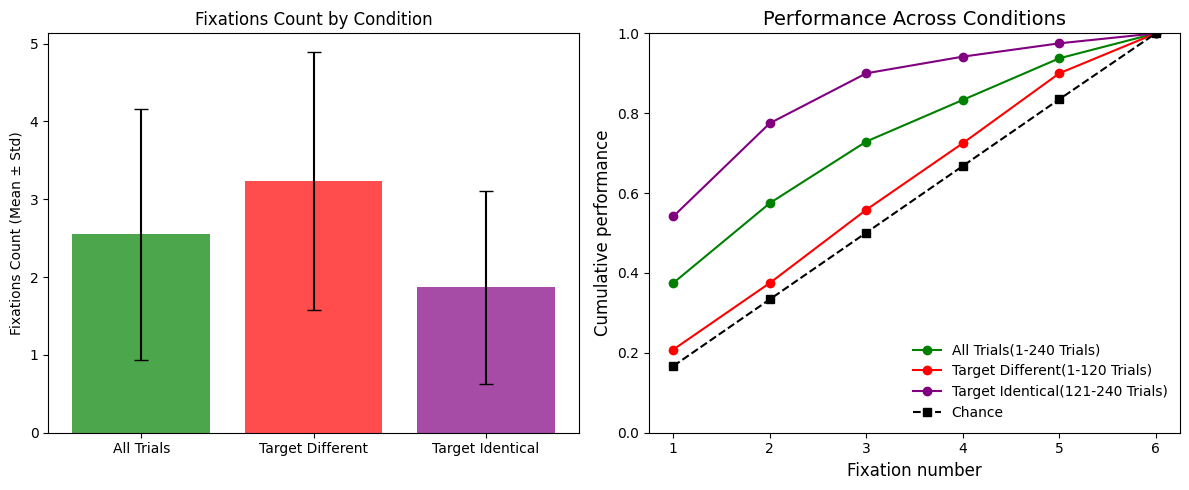

          Condition  Mean Fixations Count  Std Fixations Count
0               All              2.550000             1.609855
1  Target Different              3.233333             1.653788
2  Target Identical              1.866667             1.236241


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드
file_path = "/content/drive/MyDrive/Project/Exp1/search_results.csv"
data = pd.read_csv(file_path)

# 조건 정의
all_idx = list(range(1, 241))
target_different_idx = list(range(1,121))
target_identical_idx = list(range(121,241))

all_trials = data[data['image_idx'].isin(all_idx)]
target_different = data[data['image_idx'].isin(target_different_idx)]
target_identical = data[data['image_idx'].isin(target_identical_idx)]

# 평균과 표준편차 계산
summary = {
    "Condition": ["All", "Target Different", "Target Identical"],
    "Mean Fixations Count": [all_trials['fixations_count'].mean(),
                             target_different['fixations_count'].mean(),
                             target_identical['fixations_count'].mean()
                             ],
    "Std Fixations Count": [all_trials['fixations_count'].std()
                            ,target_different['fixations_count'].std()
                            ,target_identical['fixations_count'].std()
                            ]
}

# 데이터프레임 생성
summary_df = pd.DataFrame(summary)


# Define fixation counts (1 to 6)
fixation_counts = range(1, 7)

# Function to calculate cumulative accuracy
def calculate_cumulative_accuracy(data, start_trial, end_trial):
    """
    Calculate cumulative accuracy for fixation counts 1 to 6.

    Parameters:
        data (pd.DataFrame): Input data containing 'fixations_count' and 'found'.
        start_trial (int): Start trial index (inclusive).
        end_trial (int): End trial index (inclusive).

    Returns:
        list: Cumulative accuracy for fixation counts 1 through 6.
    """
    filtered_data = data[(data['image_idx'] >= start_trial) & (data['image_idx'] <= end_trial)]
    cumulative_accuracy = []
    for count in fixation_counts:
        # Filter trials where fixation_count <= count
        filtered_count = filtered_data[filtered_data['fixations_count'] <= count]
        total_trials = len(filtered_data)

        # Calculate accuracy for trials found within this fixation range
        accuracy = len(filtered_count[filtered_count['found'] == True]) / total_trials if total_trials > 0 else 0
        cumulative_accuracy.append(accuracy)
    return cumulative_accuracy

# Calculate cumulative accuracy for different trial ranges
cumulative_accuracy_1_120 = calculate_cumulative_accuracy(data, 1, 120)
cumulative_accuracy_121_240 = calculate_cumulative_accuracy(data, 121, 240)
cumulative_accuracy_all = calculate_cumulative_accuracy(data, 1, 240)

# Chance cumulative accuracy values
chance_cumulative_accuracy = [0.167, 0.334, 0.501, 0.668, 0.835, 1]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x_labels = ["All Trials", "Target Different", "Target Identical"]
means = summary_df["Mean Fixations Count"]
stds = summary_df["Std Fixations Count"]
axes[0].bar(x_labels, means, yerr=stds, capsize=5, alpha=0.7, color=['green', 'red', 'purple'])
axes[0].set_ylabel("Fixations Count (Mean ± Std)")
axes[0].set_title("Fixations Count by Condition")


# Plot 2: Individual Trial Ranges vs Chance
axes[1].plot(
    fixation_counts, cumulative_accuracy_all,
    marker='o', color='green', label="All Trials(1-240 Trials)", linestyle='-'
)
axes[1].plot(
    fixation_counts, cumulative_accuracy_1_120,
    marker='o', color='red', label="Target Different(1-120 Trials)", linestyle='-'
)
axes[1].plot(
    fixation_counts, cumulative_accuracy_121_240,
    marker='o', color='purple', label="Target Identical(121-240 Trials)", linestyle='-'
)
axes[1].plot(
    fixation_counts, chance_cumulative_accuracy,
    marker='s', color='black', label="Chance", linestyle='--'
)
axes[1].set_xlabel("Fixation number", fontsize=12)
axes[1].set_ylabel("Cumulative performance", fontsize=12)
axes[1].set_title("Performance Across Conditions", fontsize=14, loc='center')
axes[1].set_xticks(fixation_counts)
axes[1].set_ylim(0, 1)
axes[1].legend(fontsize=10, loc='lower right', frameon=False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


print(summary_df)

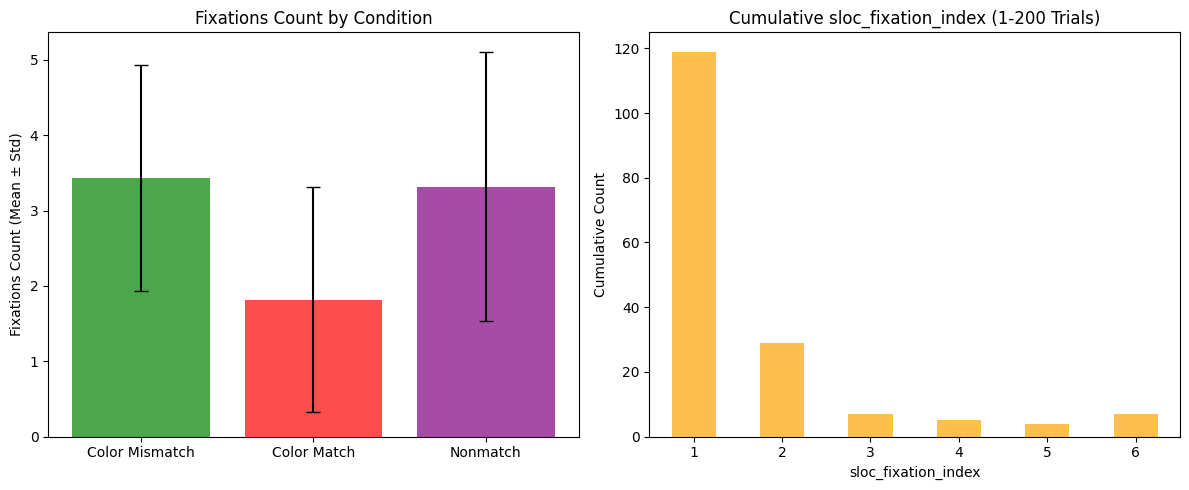


Conditions Summary:
        Condition  Mean Fixations Count  Std Fixations Count
0  Color Mismatch                  3.43             1.499192
1     Color Match                  1.82             1.500034
2        Nonmatch                  3.32             1.791563

ANOVA result (fixations_count differences between conditions):
F-statistic: 31.4906, p-value: 0.0000

sloc_fixation_index = 1 Ratio (Color Mismatch + Color Match): 0.5950
sloc_fixation_index = 1 Ratio (Color Mismatch): 0.5300
sloc_fixation_index = 1 Ratio (Color Match): 0.6600

Pairwise T-Test Results:
                       Comparison  T-statistic       P-value
0  Color Mismatch vs. Color Match     7.591573  1.217081e-12
1     Color Mismatch vs. Nonmatch     0.470874  6.382650e-01
2        Color Match vs. Nonmatch    -6.419526  1.044922e-09

Significant Pairwise Comparisons (P < 0.05):
                       Comparison  T-statistic       P-value
0  Color Mismatch vs. Color Match     7.591573  1.217081e-12
2        Color Mat

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway, ttest_ind

# 데이터 로드
file_path = "/content/drive/MyDrive/Project/Exp2/search_results.csv"
data = pd.read_csv(file_path)

# 조건 정의
color_mismatch_idx = list(range(1, 101))
color_match_idx = list(range(101, 201))
nonmatch_idx = list(range(201, 301))

# 조건별 데이터 필터링
color_mismatch = data[data['image_idx'].isin(color_mismatch_idx)]
color_match = data[data['image_idx'].isin(color_match_idx)]
nonmatch = data[data['image_idx'].isin(nonmatch_idx)]

# fixations_count의 평균과 표준편차 계산
conditions_summary = {
    "Condition": ["Color Mismatch", "Color Match", "Nonmatch"],
    "Mean Fixations Count": [
        color_mismatch['fixations_count'].mean(),
        color_match['fixations_count'].mean(),
        nonmatch['fixations_count'].mean()
    ],
    "Std Fixations Count": [
        color_mismatch['fixations_count'].std(),
        color_match['fixations_count'].std(),
        nonmatch['fixations_count'].std()
    ]
}

# 데이터프레임 생성
summary_df = pd.DataFrame(conditions_summary)

# fixations_count 차이 유의성 검정 (ANOVA)
anova_result = f_oneway(
    color_mismatch['fixations_count'],
    color_match['fixations_count'],
    nonmatch['fixations_count']
)

# sloc_fixation_index 누적값 계산
sloc_trials = data[(data['image_idx'] >= 1) & (data['image_idx'] <= 200)]
sloc_counts = sloc_trials['sloc_fixation_index'].value_counts().reindex(range(1, 7), fill_value=0)

# sloc_fixation_index가 1인 비율 계산
sloc_index_1_ratio = len(sloc_trials[sloc_trials['sloc_fixation_index'] == 1]) / len(sloc_trials)

# sloc_fixation_index가 1인 비율 (조건별)
color_mismatch_sloc_1_ratio = len(color_mismatch[color_mismatch['sloc_fixation_index'] == 1]) / len(color_mismatch)
color_match_sloc_1_ratio = len(color_match[color_match['sloc_fixation_index'] == 1]) / len(color_match)

# Pairwise T-tests for post-hoc analysis
ttest_results = {
    "Color Mismatch vs. Color Match": ttest_ind(
        color_mismatch['fixations_count'], color_match['fixations_count'], equal_var=False
    ),
    "Color Mismatch vs. Nonmatch": ttest_ind(
        color_mismatch['fixations_count'], nonmatch['fixations_count'], equal_var=False
    ),
    "Color Match vs. Nonmatch": ttest_ind(
        color_match['fixations_count'], nonmatch['fixations_count'], equal_var=False
    )
}

# Results output
pairwise_results = []
for comparison, result in ttest_results.items():
    pairwise_results.append({
        "Comparison": comparison,
        "T-statistic": result.statistic,
        "P-value": result.pvalue
    })

# Pairwise T-Test 결과 데이터프레임 생성
pairwise_df = pd.DataFrame(pairwise_results)

# 통계량을 하나의 데이터프레임으로 정리
stats_summary = {
    "Statistic": ["ANOVA F-statistic", "ANOVA P-value"] +
                 [f"{row['Comparison']} T-statistic" for _, row in pairwise_df.iterrows()] +
                 [f"{row['Comparison']} P-value" for _, row in pairwise_df.iterrows()],
    "Value": [anova_result.statistic, anova_result.pvalue] +
             list(pairwise_df["T-statistic"]) +
             list(pairwise_df["P-value"])
}
stats_summary_df = pd.DataFrame(stats_summary)

# 시각화: 두 그래프를 하나의 열에 배치
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# 첫 번째 그래프: Fixations Count (Mean ± Std)
x_labels = ["Color Mismatch", "Color Match", "Nonmatch"]
means = summary_df["Mean Fixations Count"]
stds = summary_df["Std Fixations Count"]
axs[0].bar(x_labels, means, yerr=stds, capsize=5, alpha=0.7, color=['green', 'red', 'purple'])
axs[0].set_ylabel("Fixations Count (Mean ± Std)")
axs[0].set_title("Fixations Count by Condition")

# 두 번째 그래프: sloc_fixation_index 누적값
sloc_counts.plot(kind='bar', color='orange', alpha=0.7, ax=axs[1])
axs[1].set_xlabel("sloc_fixation_index")
axs[1].set_ylabel("Cumulative Count")
axs[1].set_title("Cumulative sloc_fixation_index (1-200 Trials)")
axs[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# 결과 테이블 출력
print("\nConditions Summary:")
print(summary_df)

# ANOVA 결과 출력
print("\nANOVA result (fixations_count differences between conditions):")
print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4f}")

# sloc_fixation_index = 1 비율 출력
print(f"\nsloc_fixation_index = 1 Ratio (Color Mismatch + Color Match): {sloc_index_1_ratio:.4f}")
print(f"sloc_fixation_index = 1 Ratio (Color Mismatch): {color_mismatch_sloc_1_ratio:.4f}")
print(f"sloc_fixation_index = 1 Ratio (Color Match): {color_match_sloc_1_ratio:.4f}")

# Pairwise T-Test 결과 출력
print("\nPairwise T-Test Results:")
print(pairwise_df)

# 유의미한 Pairwise Comparisons
significant_comparisons = pairwise_df[pairwise_df['P-value'] < 0.05]
print("\nSignificant Pairwise Comparisons (P < 0.05):")
print(significant_comparisons)


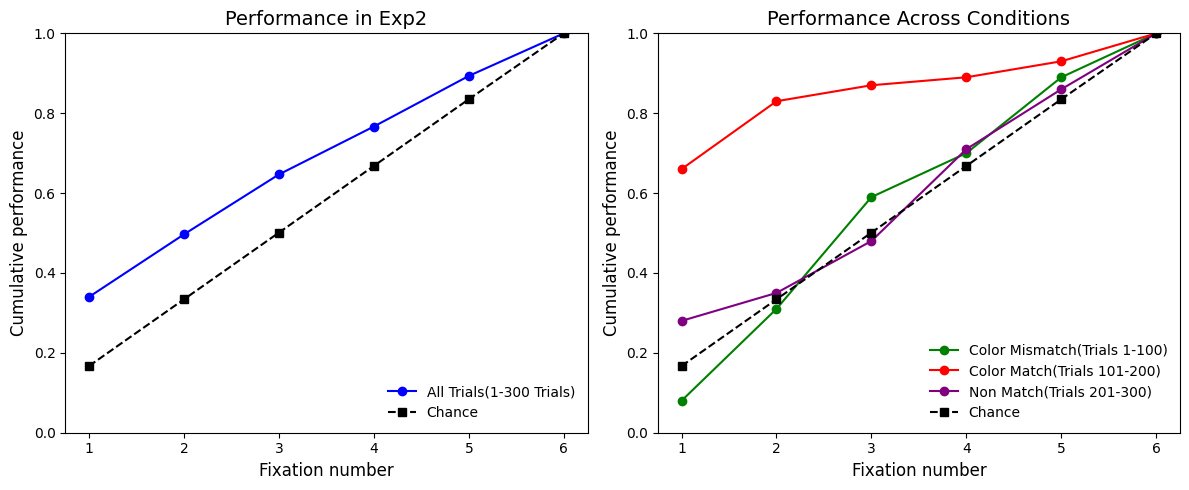

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/Project/Exp2/search_results.csv'
data = pd.read_csv(file_path)

# Calculate cumulative accuracy for different trial ranges
cumulative_accuracy_1_100 = calculate_cumulative_accuracy(data, 1, 100)
cumulative_accuracy_101_200 = calculate_cumulative_accuracy(data, 101, 200)
cumulative_accuracy_201_300 = calculate_cumulative_accuracy(data, 201, 300)
cumulative_accuracy_all = calculate_cumulative_accuracy(data, 1, 300)

# Chance cumulative accuracy values
chance_cumulative_accuracy = [0.167, 0.334, 0.501, 0.668, 0.835, 1]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: All Trials vs Chance
axes[0].plot(
    fixation_counts, cumulative_accuracy_all,
    marker='o', color='blue', label="All Trials(1-300 Trials)", linestyle='-'
)
axes[0].plot(
    fixation_counts, chance_cumulative_accuracy,
    marker='s', color='black', label="Chance", linestyle='--'
)
axes[0].set_xlabel("Fixation number", fontsize=12)
axes[0].set_ylabel("Cumulative performance", fontsize=12)
axes[0].set_title("Performance in Exp2", fontsize=14, loc='center')
axes[0].set_xticks(fixation_counts)
axes[0].set_ylim(0, 1)
axes[0].legend(fontsize=10, loc='lower right', frameon=False)

# Plot 2: Individual Trial Ranges vs Chance
axes[1].plot(
    fixation_counts, cumulative_accuracy_1_100,
    marker='o', color='green', label="Color Mismatch(Trials 1-100)", linestyle='-'
)
axes[1].plot(
    fixation_counts, cumulative_accuracy_101_200,
    marker='o', color='red', label="Color Match(Trials 101-200)", linestyle='-'
)
axes[1].plot(
    fixation_counts, cumulative_accuracy_201_300,
    marker='o', color='purple', label="Non Match(Trials 201-300)", linestyle='-'
)
axes[1].plot(
    fixation_counts, chance_cumulative_accuracy,
    marker='s', color='black', label="Chance", linestyle='--'
)
axes[1].set_xlabel("Fixation number", fontsize=12)
axes[1].set_ylabel("Cumulative performance", fontsize=12)
axes[1].set_title("Performance Across Conditions", fontsize=14, loc='center')
axes[1].set_xticks(fixation_counts)
axes[1].set_ylim(0, 1)
axes[1].legend(fontsize=10, loc='lower right', frameon=False)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()